In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
from textblob import TextBlob

In [2]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [3]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    text = str(text)
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub('\n'," ",text)
    text = re.sub('\r'," ",text)
    return text

def mlist(story):
    return [text_cleaner(i) for i in TextBlob(re.sub(r'Chapter \d+', '', story)).sentences]

def mtokens(story):
    return [list(i.words.lower()) for i in TextBlob(re.sub(r'Chapter \d+', '', story)).sentences]

In [4]:
# Load and clean the data.
chestertonbrown = mlist(gutenberg.raw('chesterton-brown.txt'))
edgeworth = mlist(gutenberg.raw('edgeworth-parents.txt'))
alice = mlist(gutenberg.raw('carroll-alice.txt'))

In [5]:
sentences = chestertonbrown + alice + edgeworth

In [6]:
def nl(name,data):
    return [name for i in range(len(data))]
name = nl('chesterton',chestertonbrown)+nl('edgeworth',edgeworth)+nl('carroll',alice)

In [7]:
stories = pd.DataFrame([sentences,name]).T.sample(frac=1.0,random_state=42)
stories.columns = ['sentence','author']

In [8]:
stories

,sentence,author
10289,He never could see it.,edgeworth
3101,"""Oh, there are sermons in a cruet-stand, too,""...",chesterton
862,I can't describe these things; I know what I m...,chesterton
4269,"'I've tried the roots of trees, and I've tried...",edgeworth
14205,The shillings were soon gone.,carroll
14641,A few days ago I had fine things in readiness...,carroll
10846,Will.,edgeworth
9144,Lord J.,edgeworth
4738,"In another minute the whole head appeared, and...",edgeworth
5814,"""Oh, pugh!",edgeworth


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test = train_test_split(sentences, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.3,
                             min_df=3,
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
stories_paras_tfidf=vectorizer.fit_transform(sentences)
print("Number of features: %d" % stories_paras_tfidf.get_shape()[1])

Number of features: 5418


In [11]:
#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train,y_test = train_test_split(stories_paras_tfidf, stories.author,test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

In [12]:
#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Original sentence: Ask Tom."
Tf_idf vector: {'tom': 0.8050193182596304, 'ask': 0.5932485964827898}


In [13]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [26]:
#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(400)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

In [27]:
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 47.130552524579585


In [28]:
#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:2])
    print('___________________________________')

Component 0:
said she; "then I can't  have it.    0.880765
I said "What for?"'                  0.880765
Name: 0, dtype: float64
___________________________________
Component 1:
Just.    0.812595
Just.    0.812595
Name: 1, dtype: float64
___________________________________
Component 2:
"Oh, why, famous means now, don't you know what famous means?    0.558572
"Oh, don't you see?"                                             0.556979
Name: 2, dtype: float64
___________________________________
Component 3:
"Oh!    0.80355
"Oh!    0.80355
Name: 3, dtype: float64
___________________________________
Component 4:
Then he said at last, "Don't you know who he is?"    0.568516
"Don't you know whose it is?"                        0.563702
Name: 4, dtype: float64
___________________________________


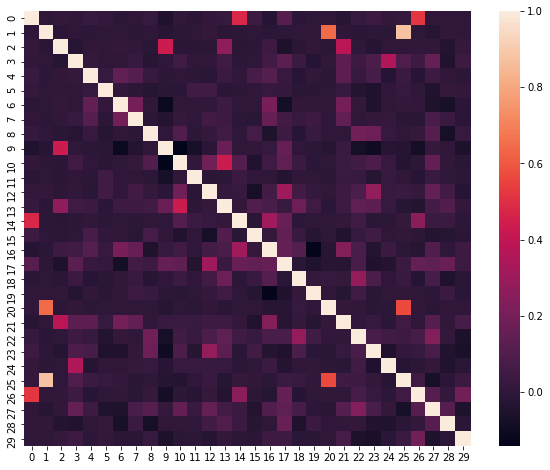

Key:
0 A thought, a provident thought, now struck Fisher; for even he had some  foresight where his favourite passion was concerned.
1 "Do you think I would give them to you if they were not my own?"
2 "Where are your bow and arrows, my little man?"
3 Do you know he has found a  treasure, he says, in his father's garden a vase full of gold?
4 "Then," said Archer, "stand out in the right and  be free."
5 Ask Tom."
6 said  he, patting him, and then could not refrain from counting out his money.
7 "Thank you," said Mr Butler, K.C., and sat down suddenly, as if he had got what he wanted.
8 His friend, Flambeau, a semi-official investigator, was sitting opposite him, making his last notes of a case he had cleared up in the neighbourhood.
9 He was also refreshingly lucid, as he was on the committees.
10 They hesitate between new motives and old principles.
11 Oh, Paul, you forgot.
12 Miss Etta Todd is one of our deep-souled New Yorkers, and comes into an income of nearly twelve hundred milli

In [14]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:30,0:30]
#Making a plot
plt.figure(figsize=(10,8))
ax = sns.heatmap(sim_matrix,yticklabels=range(30))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(30):
    print(i,sim_matrix.index[i])

### _K Means Clustering_

In [15]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [16]:
%%time
km_range = range(2,8)
km_predict = []
for i in km_range:
    # Declare and fit the model.
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(X_train_tfidf)
    km_predict.append(km.predict(X_test_tfidf))

    #Predicted clusters.
    print('{} completed'.format(i),end=' | ')

2 completed | 3 completed | 4 completed | 5 completed | 6 completed | 7 completed | CPU times: user 1min 14s, sys: 1.16 s, total: 1min 16s
Wall time: 41.4 s


In [17]:
%%time
mb_range = range(2,8)
mb_predict = []
for i in mb_range:
    # Declare and fit the model.
    mb = MiniBatchKMeans(
                        init='random',
                        n_clusters=i,
                        batch_size=10)
    mb.fit(X_train_tfidf)
    mb_predict.append(mb.predict(X_test_tfidf))

    #Predicted clusters.
    print('{} completed'.format(i),end=' | ')

2 completed | 3 completed | 4 completed | 5 completed | 6 completed | 7 completed | CPU times: user 4.43 s, sys: 69.1 ms, total: 4.5 s
Wall time: 2.37 s


# 5. Evaluate (w/ different criterion)

In [18]:
from sklearn.metrics import v_measure_score

## _V-Measurement Criterion_

_KMeans_

In [19]:
table = pd.crosstab(y_test, km_predict[1],margins = True)
table.index = list(stories.author.unique()) + ['total'];table

col_0,0,1,2,All
edgeworth,75,28,571,674
chesterton,190,59,1226,1475
carroll,470,169,3386,4025
total,735,256,5183,6174


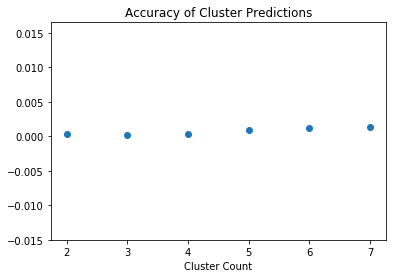

In [20]:
plt.scatter(x=[km_range],y=[v_measure_score(y_test,v) for v in  km_predict])
plt.title('Accuracy of Cluster Predictions')
plt.xlabel('Cluster Count')
plt.show()

_Minibatch_

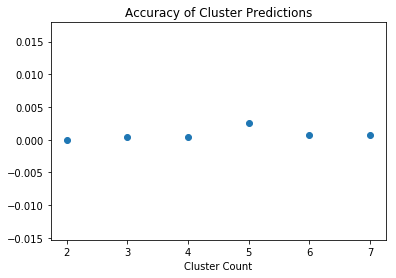

In [21]:
plt.scatter(x=[mb_range],y=[v_measure_score(y_test,v) for v in  mb_predict])
plt.title('Accuracy of Cluster Predictions')
plt.xlabel('Cluster Count')
plt.show()